# The Red Line Problem

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Plots", "KernelDensity", "Statistics", "Distributions")

In [2]:
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
];

In [3]:
zs = observed_gap_times ./ 60;

In [4]:
include("empiricaldist.jl"); using .EmpiricalDist

In [5]:
qs = range(0, 20, length=101)
pmf_z = kde_from_sample(zs, qs);

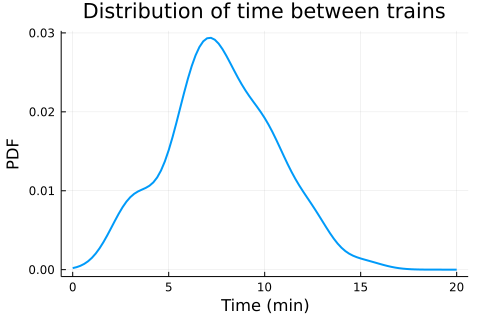

In [6]:
using Plots
plot(pmf_z)

xlabel!("Time (min)")
ylabel!("PDF")
title!("Distribution of time between trains")

In [7]:
likelihood = pmf_z.qs;

In [8]:
posterior_z = pmf_z .* pmf_z.qs
normalize!(posterior_z)

7.770318400631156

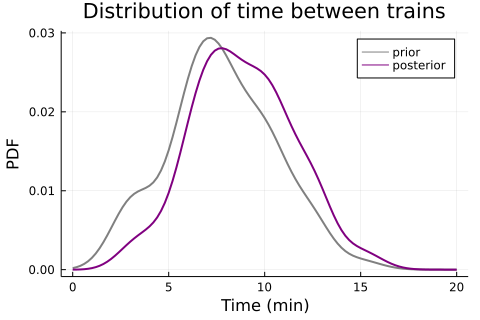

In [9]:
plot(pmf_z, label="prior", color=:gray)
plot!(posterior_z, label="posterior", color=:purple)

xlabel!("Time (min)")
ylabel!("PDF")
title!("Distribution of time between trains")

In [10]:
using Statistics
mean(pmf_z), mean(posterior_z)

(7.770318400631157, 8.863101685795783)

## Elapsed time

In [11]:
function make_elapsed_dist(gap, qs)
    qs = qs[qs .<= gap]
    n = length(qs)
    return Pmf(1/n, qs)
end

make_elapsed_dist (generic function with 1 method)

In [12]:
qs = posterior_z.qs
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs];

In [13]:
pmf_seq[4]

┌─────┬───────┐
│     │ probs │
├─────┼───────┤
│ 0.0 │  0.25 │
│ 0.2 │  0.25 │
│ 0.4 │  0.25 │
│ 0.6 │  0.25 │
└─────┴───────┘


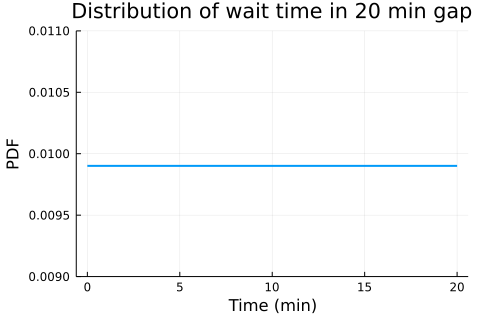

In [14]:
plot(pmf_seq[end], ylim=(0.009, 0.011), 
    xlabel="Time (min)", ylabel="PDF",
    title="Distribution of wait time in 20 min gap")

In [15]:
pmf_x = makemixture(posterior_z, pmf_seq);

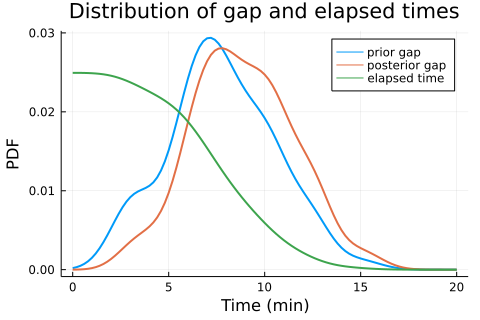

In [16]:
plot(pmf_z, label="prior gap")
plot!(posterior_z, label="posterior gap")
plot!(pmf_x, label="elapsed time")

xlabel!("Time (min)")
ylabel!("PDF")
title!("Distribution of gap and elapsed times")

In [17]:
mean(posterior_z), mean(pmf_x)

(8.863101685795783, 4.4315508428978925)

## Counting passengers

In [18]:
using Distributions
λ = 2
num_passengers = 10
likelihood = pdf.(Poisson.(λ .* pmf_x.qs), num_passengers);

In [19]:
posterior_x = pmf_x .* likelihood
normalize!(posterior_x)

0.0477387787859386

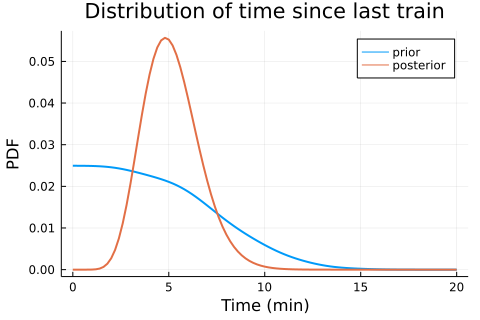

In [20]:
plot(pmf_x, label="prior")
plot!(posterior_x, label="posterior")
xlabel!("Time (min)")
ylabel!("PDF")
title!("Distribution of time since last train")

In [21]:
mean(pmf_x), mean(posterior_x)

(4.4315508428978925, 5.143107910521239)

## Wait time

In [22]:
posterior_y = subdist(posterior_z, posterior_x);

In [23]:
nonneg = (posterior_y.qs .>= 0)
posterior_y = Pmf(posterior_y[nonneg])
normalize!(posterior_y)

0.8906336373552605

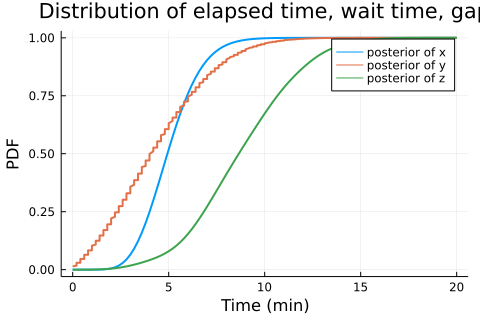

In [24]:
plot(makecdf(posterior_x), label="posterior of x")
plot!(makecdf(posterior_y), label="posterior of y")
plot!(makecdf(posterior_z), label="posterior of z")

xlabel!("Time (min)")
ylabel!("PDF")
title!("Distribution of elapsed time, wait time, gap")

## Decision analysis

In [25]:
samp = sample(posterior_z, 260)
delays = [30, 40, 50]
augmented_sample = vcat(samp, delays);

In [26]:
qs = range(0, 60, length=101)
augmented_posterior_z = kde_from_sample(augmented_sample, qs);

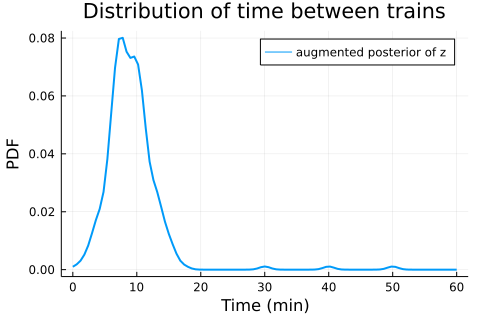

In [27]:
plot(augmented_posterior_z, label="augmented posterior of z", 
    xlabel="Time (min)", ylabel="PDF", title="Distribution of time between trains")

In [28]:
qs = augmented_posterior_z.qs
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs]
pmf_x = makemixture(augmented_posterior_z, pmf_seq)
lam = 2
num_passengers = 10

"""Distribution of wait time based on `num_passengers`."""
function compute_posterior_y(num_passengers)
    likelihood = pdf.(Poisson.(lam .* qs), num_passengers)
    posterior_x = pmf_x .* likelihood
    normalize!(posterior_x)
    posterior_y = subdist(augmented_posterior_z, posterior_x)
    nonneg = (posterior_y.qs .>= 0)
    posterior_y = Pmf(posterior_y[nonneg])
    normalize!(posterior_y)
    return posterior_y
end

compute_posterior_y

In [29]:
posterior_y = compute_posterior_y(10);

In [30]:
mean(posterior_y)

4.7950804699890694

In [31]:
1 - makecdf(posterior_y)(15)

0.013029260634577766

In [32]:
nums = 0:3:36
posteriors = [compute_posterior_y(num) for num in nums];

In [33]:
mean_wait = [mean(posterior_y)
             for posterior_y in posteriors];

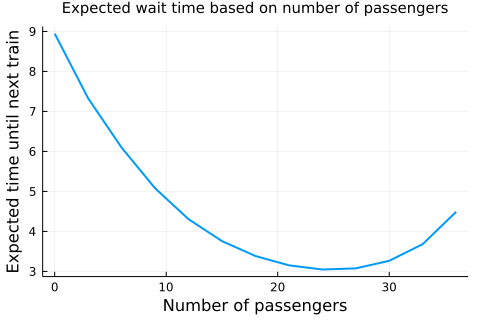

In [34]:
plot(nums, mean_wait)

xlabel!("Number of passengers")
ylabel!("Expected time until next train")
title!("Expected wait time based on number of passengers", titlefontsize=10)

In [35]:
prob_late = [1 - makecdf(posterior_y)(15) 
             for posterior_y in posteriors];

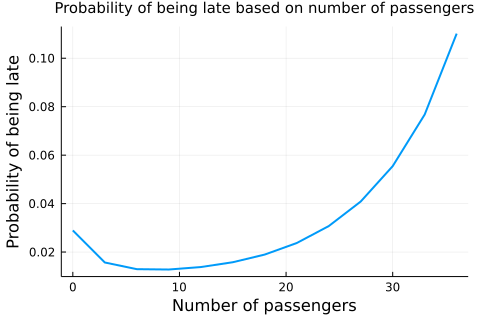

In [36]:
plot(nums, prob_late)

xlabel!("Number of passengers")
ylabel!("Probability of being late")
title!("Probability of being late based on number of passengers", titlefontsize=10)